#### 1. Importing Libraries

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [ ]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from keras.layers import *
from keras.losses import *
from keras.models import *
from keras.metrics import *
from keras.optimizers import *
from keras.applications import *
from keras.utils import load_img

# For Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Miscellaneous
import pandas as pd
from tqdm import tqdm
import os
import random

#### 2. Data Preparation

##### 2.1 Training dataset

In [3]:
real_train_csv = "../../../pre_processed_data/Training/train.csv"
train_csv_path = "../../../pre_processed_data/Training/mini_train.csv"

# Seed for reproducibility
seed = 42

real_data = pd.read_csv(real_train_csv)
train_data = pd.read_csv(train_csv_path)

# Create a set of paths in train_data for quick lookup
existing_paths = set(train_data['Path'])

labels = train_data['Label'].unique()

train_paths = []
train_labels = []

for label in labels:
    # Add from train_data
    train_filtered = train_data[train_data['Label'] == label]
    train_paths.extend(train_filtered['Path'][:72].tolist())
    train_labels.extend(train_filtered['Label'][:72].tolist())
    
    # Add from real_data, ensuring they are not already in train_data
    real_selected = real_data[(real_data['Label'] == label) & (~real_data['Path'].isin(existing_paths))]
    if len(real_selected) < 72:
        print(f"Warning: Not enough unique generated images for label {label}. Available: {len(real_selected)}")
    else:
        real_selected = real_selected.sample(n=72, random_state=seed)
    train_paths.extend(real_selected['Path'].tolist())
    train_labels.extend(real_selected['Label'].tolist())

# Shuffle train data
train_paths, train_labels = shuffle(train_paths, train_labels, random_state=seed)

# Creating a new DataFrame from the shuffled data
train_data = pd.DataFrame({'Path': train_paths, 'Label': train_labels})

# Print to verify the distribution
print(train_data['Label'].value_counts())

train_paths = train_data['Path'].tolist()
train_labels = train_data['Label'].tolist()

Label
meningioma    90
glioma        90
pituitary     90
notumor       90
Name: count, dtype: int64


In [4]:
import tensorflow as tf

# Set the seed for random number generators in numpy, random, and tensorflow
seed_value = 66
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

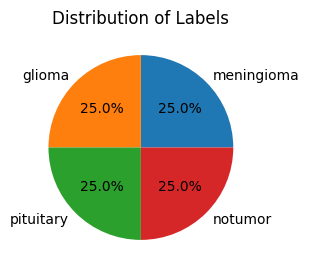

In [5]:
# Plotting a pie chart for the 'label' column
label_counts = train_data['Label'].value_counts()
plt.figure(figsize=(3, 3))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Labels')
plt.show()

##### 2.2 Testing dataset

In [6]:
test_data = pd.read_csv("../../../pre_processed_data/Testing/test.csv")

# Extracting paths and labels from the Testing dataframe
test_paths = test_data['Path'].tolist() 
test_labels = test_data['Label'].tolist()

# Shuffling the paths and labels
test_paths, test_labels = shuffle(test_paths, test_labels)

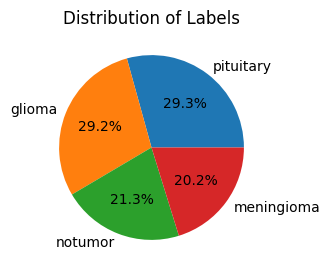

In [7]:
# Plotting a pie chart for the 'label' column
label_counts = test_data['Label'].value_counts()
plt.figure(figsize=(3, 3))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Labels')
plt.show()

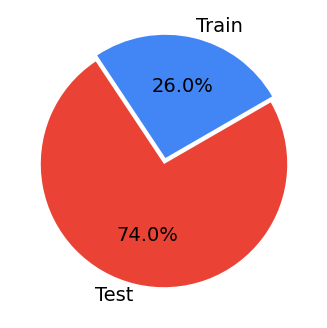

In [8]:
plt.figure(figsize=(8,4))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

##### 3.1 Examples

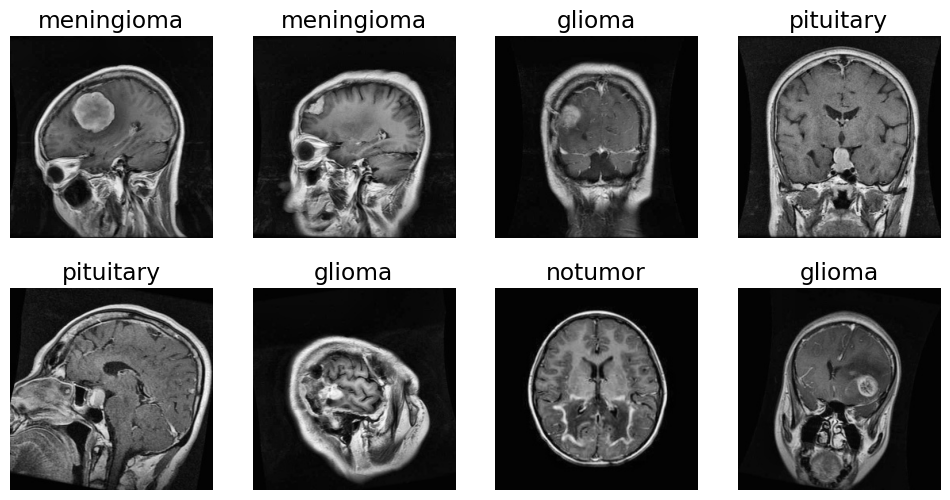

In [9]:
IMAGE_SIZE = 256

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = np.array(image)  # Convert the image to a NumPy array
        images.append(image)
    return np.array(images)

# Assuming train_paths and train_labels are defined
images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

#### 4. Data Generator
Given a list of paths to images, and the labels, this function encodes the label, and then returns the batch on which the model can train on.

In [10]:
unique_labels = list(set(train_labels))

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

#### 5. Model `VGG19`

In [ ]:
base_model = VGG19(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')

# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [12]:
batch_size = 32
steps = int(len(train_paths)/batch_size)
epochs = 5
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/5
11/11 [==============================] - 34s 3s/step - loss: 4.1965 - sparse_categorical_accuracy: 0.5739
Epoch 2/5
11/11 [==============================] - 33s 3s/step - loss: 0.5961 - sparse_categorical_accuracy: 0.8018
Epoch 3/5
11/11 [==============================] - 32s 3s/step - loss: 0.2754 - sparse_categorical_accuracy: 0.9146
Epoch 4/5
11/11 [==============================] - 32s 3s/step - loss: 0.1656 - sparse_categorical_accuracy: 0.9482
Epoch 5/5
11/11 [==============================] - 36s 3s/step - loss: 0.1281 - sparse_categorical_accuracy: 0.9634


#### 6. Evaluation

In [ ]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

In [14]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      glioma       0.90      0.70      0.78       299
  meningioma       0.63      0.77      0.69       207
     notumor       0.99      0.93      0.96       218
   pituitary       0.85      0.96      0.90       300

    accuracy                           0.84      1024
   macro avg       0.84      0.84      0.83      1024
weighted avg       0.85      0.84      0.84      1024

